In [1]:
# Requirements for Sample Creation and Descriptive Analysis
import pandas as pd
import numpy as np

import networkx as nx
from networkx.algorithms.community import k_clique_communities

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data with Self-Loops Excluded
trans_3w = pd.read_csv('trans_3w_cl.csv')
trans_3w.shape

(12579089, 9)

In [3]:
# Remove Negative Ammounts
trans_3w = trans_3w[trans_3w.ammount > 0]
trans_3w.shape

(12529162, 9)

In [4]:
# Get list of fraudulent/high-risk nodes

input_fr = trans_3w[trans_3w['input_flag'] == 1]
infr = input_fr['input_address'].tolist()

output_fr = trans_3w[trans_3w['output_flag'] == 1]
outfr = output_fr['output_address'].tolist()

fr_nodes = set(infr + outfr)
print('Number of Fraudulent/High-Risk Addresses: ', len(fr_nodes))

Number of Fraudulent/High-Risk Addresses:  4530


In [5]:
del input_fr, infr, output_fr, outfr # Removals due to MemoryError Concerns

In [6]:
# Obtain full network NetworkX Graph (no self-loops)
G_full = nx.from_pandas_edgelist(trans_3w, 'input_address', 'output_address', edge_attr=['ammount', 'fees', 'block_time',
                                'input_flag', 'output_flag'], create_using=nx.MultiDiGraph())

In [7]:
del trans_3w

In [8]:
# Generator for giant component
giant = max(nx.connected_components(G_full.to_undirected()))

# Get sub-graph of Giant Component
G_giant_u = G_full.subgraph(giant)
G_giant_d = G_giant_u.to_directed()

In [9]:
del G_full

In [10]:
# Keep Only Fraudulent nodes in Giant Component

fr_nodes = list(set(list(G_giant_u.nodes)).intersection(fr_nodes))
len(fr_nodes)

4361

In [11]:
# Adjusted Chosen Sampler to Centre Exploration Around Fraudulent/High-Risk Nodes

def sampling_the_graph(graph_directed, graph_undirected, fraud_sample, number_of_nodes):
    
    selected_nodes = []
    
    for i in fraud_sample:                                                 # for each fraudulent/high-risk node
        fr_neighbors = [node for node in graph_undirected.neighbors(i)]    # find neighbors
        if fr_neighbors != []:                                             # if the node has neighbors
            fr_adj = random.choice(fr_neighbors)                           # choose 1 neighbor
            if fr_adj not in fraud_sample:                                 # check if neighbor isn't already included
                if fr_adj not in selected_nodes:
                    selected_nodes.append(fr_adj)                          # add to selection
            else:                                                          # if selection not made
                if len(fr_neighbors) > 1:                                  # if node has more than 1 neighbor
                    fr_neighbors.remove(fr_adj)                            # remove previous invalid choice as neighbor
                    fr_adj2 = random.choice(fr_neighbors)                  # choose new neighbor
                    if fr_adj2 not in fraud_sample:                        # check if already included
                        if fr_adj2 not in selected_nodes:
                            selected_nodes.append(fr_adj2)                 # if not included, add neighbor as selection
                else:
                    fraud_sample.remove(i)                                 # if no neighbor found remove node (reduces isolates)
    
    selected_nodes.extend(fraud_sample)                                    # combine fraud and selected neighbors list
    list_of_nodes = list(set(list(graph_undirected.nodes)) - set(selected_nodes)) # determine amount required to reach the set number of nodes
    
    first_node = random.choice(list_of_nodes)                              # randomly choose starting node
    selected_nodes.append(first_node)                                      # add node to selection
    
    while len(selected_nodes) != number_of_nodes:                          # until the set number of nodes is reached
                                                                           # follow similar neighbor sampling procedure as before
        next_candidates =  [node for node in graph_undirected.neighbors(selected_nodes[-1])] 
        if next_candidates != []:                                          
            next_node = random.choice(next_candidates)                     
            if next_node not in selected_nodes:                            
                selected_nodes.append(next_node)                            
            else: 
                next_node = random.choice(list_of_nodes)
                if next_node not in selected_nodes:
                    selected_nodes.append(next_node)
                else:
                    pass
        else:
            next_node = random.choice(list_of_nodes)
            if next_node not in selected_nodes:
                selected_nodes.append(next_node)
            else:
                pass
        
    return graph_directed.subgraph(selected_nodes).copy()

In [12]:
# Get Sample
G_sample = sampling_the_graph(G_giant_d, G_giant_u, fr_nodes, 60000)
print(nx.info(G_sample))

MultiDiGraph with 60000 nodes and 178724 edges


In [13]:
# Remove isolates (better data for the embedding and isolates are not representative of the data)
G_sample.remove_nodes_from(list(nx.isolates(G_sample)))
print(nx.info(G_sample))

MultiDiGraph with 51856 nodes and 178724 edges


In [14]:
del G_giant_d, G_giant_u

In [15]:
nx.write_pajek(G_sample, 'RW_Adjusted.net')

*Sample Analysis*

In [16]:
# Get DataFrame
sample_df = nx.to_pandas_edgelist(G_sample) 
sample_df.head()

,source,target,fees,input_flag,block_time,ammount,output_flag
0,1DTDEcM7z2Rb3GfsMgmWNCZicYuigDy7jn,13RtxCzj9gCmJ3a3RS2qVszG7TPwFcJjy7,4548.151244,0,2017-02-20 10:10:41,2.003360e+06,1
1,1DTDEcM7z2Rb3GfsMgmWNCZicYuigDy7jn,1Gr8ScMEYStmDV1C1PHupj6tobqWboez4C,10141.848756,0,2017-02-20 10:10:41,4.467260e+06,0
2,179SbVMJ6tCkNvpKGuxANfTRmc4FsVd15B,171nHhkjQuA9LfCqNNBD8g3BsXUxcDEQhT,26.573580,0,2017-02-17 08:55:36,2.421987e+04,0
3,1NKHxfjPtc4wM4r9aT7rJexwRHudwgEoZB,32tzqhVGFsBgoDKfxHJTbQfx8kV2gog8JZ,804.666047,0,2017-02-17 18:22:45,9.925431e+05,0
4,1KREz64jTd3wHbaKEPD4wh6rLnvbEnixXp,1HBDmGchTfNuoqKhjyYw5DzGUncwsULmSx,31268.587819,0,2017-02-23 17:01:41,6.840141e+06,0


In [17]:
# Number of unique input addresses
sample_df['source'].nunique()

37153

In [18]:
# Number of unique output addresses
sample_df['target'].nunique()

33890

Good variety of input and output addresses. Near balance between input and output addresses is also representative.

In [19]:
# View transaction properties
sample_df.describe()

,fees,input_flag,ammount,output_flag
count,1.787240e+05,178724.000000,1.787240e+05,178724.000000
mean,1.308529e+04,0.025967,4.526818e+07,0.249340
std,5.230025e+04,0.159039,7.140305e+08,0.432632
min,0.000000e+00,0.000000,1.541388e-03,0.000000
25%,1.162407e+02,0.000000,3.507868e+04,0.000000
50%,2.060044e+03,0.000000,6.682752e+05,0.000000
75%,1.519264e+04,0.000000,8.321355e+06,0.000000
max,6.451863e+06,1.000000,2.683366e+11,1.000000


Distribution of fees and amounts are representative of the overall data.

In [20]:
# Number of unique timestamps
sample_df['block_time'].nunique() # Almost all different timestamps included

1569

In [21]:
# Get Node Properties

address = [node for (node, val) in G_sample.degree()]
degree = [val for (node, val) in G_sample.degree()]
in_degree = [val for (node, val) in G_sample.in_degree()]
out_degree = [val for (node, val) in G_sample.out_degree()]
#eigen_centrality = nx.eigenvector_centrality(G_sample) # NetworkXNotImplemented: not implemented for multigraph type
#eigen_centrality = [eigen_centrality[node] for node in eigen_centrality]

In [22]:
# Add Properties to DataFrame

nodes_sample = pd.DataFrame()
nodes_sample['address'] = address
nodes_sample['degree'] = degree
nodes_sample['in_degree'] = in_degree
nodes_sample['out_degree'] = out_degree
#nodes_sample['eigen_centrality'] = eigen_centrality

In [23]:
# Add fraud flag

nodes_sample = nodes_sample.assign(**dict.fromkeys(['fraud_flag'], 0))

for i in fr_nodes:
    nodes_sample.loc[nodes_sample.address == i, 'fraud_flag'] = 1
    
nodes_sample.head()

,address,degree,in_degree,out_degree,fraud_flag
0,1DTDEcM7z2Rb3GfsMgmWNCZicYuigDy7jn,2,0,2,0
1,13X1s4yVdf6vKRLDZcn9HfobATMEAi5hWK,2,2,0,0
2,14oWdnfabS4XbRw5DKMz67YL7mvaUA4tNi,1,1,0,0
3,179SbVMJ6tCkNvpKGuxANfTRmc4FsVd15B,2,1,1,0
4,1AATCoSn5kLXF4XB77aDJniUEFm1A35sD1,8,8,0,0


In [24]:
# Describe sample properties overall
nodes_sample[['degree', 'in_degree', 'out_degree']].describe()

,degree,in_degree,out_degree
count,51856.000000,51856.000000,51856.000000
mean,6.893089,3.446544,3.446544
std,76.168895,43.449918,47.634430
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000
75%,3.000000,1.000000,1.000000
max,6993.000000,3319.000000,4359.000000


In [25]:
# Describe Properties of Fraudulent Nodes

nodes_s_fraud = nodes_sample[nodes_sample['fraud_flag'] == 1]
nodes_s_fraud[['degree', 'in_degree', 'out_degree']].describe()

,degree,in_degree,out_degree
count,3790.000000,3790.000000,3790.000000
mean,28.502375,12.114776,16.387599
std,239.230014,121.878013,152.294342
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,0.000000,2.000000
75%,7.000000,2.000000,4.000000
max,6993.000000,3319.000000,4359.000000


In [26]:
# Describe Properties of Non-Fraudulent Nodes

nodes_s_licit = nodes_sample[nodes_sample['fraud_flag'] == 0]
nodes_s_licit[['degree', 'in_degree', 'out_degree']].describe()

,degree,in_degree,out_degree
count,48066.000000,48066.000000,48066.000000
mean,5.189198,2.763055,2.426143
std,41.326592,29.315445,24.603726
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000
75%,3.000000,1.000000,1.000000
max,3313.000000,2382.000000,3021.000000


Degree distributions are close to the full dataset, but is slightly more skewed towards higher degree nodes.

In [27]:
# Density
nx.density(G_sample) # Graph remains weekly connected

6.646503281183846e-05

In [28]:
# Communities - k-Cliques

com_generator = k_clique_communities(G_sample.to_undirected(), k=10)
com = next(com_generator)
print('The number of communities in sample is : ' + str(len(com))) 

The number of communities in sample is : 19


Adequate variety in community structures.

In [29]:
del sample_df, address, degree, in_degree, out_degree, nodes_s_fraud, nodes_s_licit, com_generator, com

*Benchmark Embedding with Node2Vec*

In [30]:
# Requirements for test embeddings and classification
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [31]:
nx.is_weighted(G_sample)

False

In [32]:
# Adjustment to make embedding work
for u,v,d in G_sample.edges(data=True):
    d['weight'] = 1
    
nx.is_weighted(G_sample)

True

*Trans2Vev Parameters*

In [33]:
# Node2Vec Embedding from Leskovec‬ - Use parameters set in trans2vec paper

trans2vec = Node2Vec(G_sample, dimensions=64, p=0.25, q=0.75, walk_length=5, num_walks=20, seed=42)
model = trans2vec.fit(window=10)

Computing transition probabilities:   0%|          | 0/51856 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


In [34]:
# Get Embedding as DataFrame

emb_df = (pd.DataFrame([model.wv.get_vector(str(n)) for n in G_sample.nodes()]))
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.038164,-0.239175,0.167899,0.249972,-0.011883,-0.034026,0.103758,0.212007,-0.063214,-0.061415,...,0.008495,0.028267,0.103765,-0.405222,-0.224229,0.204520,0.078716,0.111394,-0.074168,0.091364
1,-0.050084,-0.017901,-0.058803,0.362675,-0.081313,-0.453174,-0.149921,0.622479,-0.273260,0.024694,...,-0.031470,0.323750,0.375472,-0.582442,-0.329376,-0.098313,0.124539,-0.190466,-0.453323,-0.030641
2,0.105577,0.115944,0.388683,0.273821,0.071534,-0.272027,-0.130935,0.691015,0.078144,-0.135209,...,0.178249,0.432790,0.151647,-0.156447,-0.328040,0.436759,-0.047070,0.116126,-0.280103,0.223965
3,0.026996,-0.068618,0.141477,0.167249,-0.056948,-0.210644,-0.040966,0.117153,-0.006748,-0.010384,...,0.095370,0.006963,0.050227,-0.211998,-0.059738,0.156287,0.038605,-0.002400,-0.089662,-0.004154
4,0.160790,-0.761089,-0.176192,0.676253,-0.241109,-0.797080,0.390757,0.485474,-0.658676,0.034228,...,0.229378,0.164472,0.770675,-0.566770,-0.578354,0.370799,0.114533,-0.309339,-0.173818,0.233503


In [35]:
# Get target variabel

flag = nodes_sample['fraud_flag']

In [36]:
# Get train-test-split

x_train, x_test, y_train, y_test = train_test_split(emb_df, flag, test_size=0.2, random_state=42)

In [37]:
# Extreme Gradient Boosting (XGBoost)

# Instanciate Model
xgbc = XGBClassifier(random_state=42)

# Hyperparameters grid
xgb_grid = {'gamma': [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8],
            'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            'max_depth': range(3,10),
            'n_estimators': range(50,100),
            'reg_alpha': [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8],
            'reg_lambda': [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8]}

# Set RandomisedSearch
xgb = RandomizedSearchCV(estimator=xgbc, param_distributions=xgb_grid, scoring='f1', random_state=42, cv=10)

# Fit RandomisedSearch to training data
xgb.fit(x_train, y_train)

# List best hyperparameters
print("Best estimator for XGBoost Classifier:\n", xgb.best_estimator_)

Best estimator for XGBoost Classifier:
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)


In [38]:
# Set Model
xgbc = XGBClassifier(gamma=0.4, learning_rate=0.6, max_depth=7, n_estimators=90, reg_alpha=0.4, reg_lambda=1.6,
                     random_state=42)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)

In [39]:
# Performance

pred_tr = xgbc.predict(x_train)
pred_tst = xgbc.predict(x_test)

print('Classifier with trans2vec hyperparameter embeddings')
print(' ')
print('Scores for flag=1')
print('In-sample F1 score: ', f1_score(y_train, pred_tr))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst))
print('In-sample Recall score: ', recall_score(y_train, pred_tr))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst))
print(' ')
print('Overall Scores')
print('In-sample F1 score: ', f1_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst, average='weighted'))
print('In-sample Recall score: ', recall_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst, average='weighted'))

Classifier with trans2vec hyperparameter embeddings
 
Scores for flag=1
In-sample F1 score:  0.999503393477901
Out-of-sample F1 score:  0.23069001029866115
In-sample Recall score:  0.999007279947055
Out-of-sample Recall score:  0.14583333333333334
 
Overall Scores
In-sample F1 score:  0.9999276664156598
Out-of-sample F1 score:  0.908054612020322
In-sample Recall score:  0.9999276829621059
Out-of-sample Recall score:  0.9279791747011183


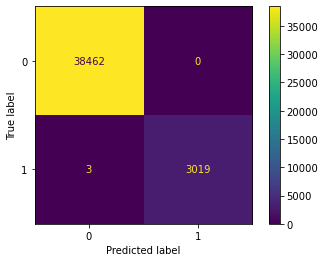

In [40]:
# Confusion matrix - training

cm = confusion_matrix(y_train, pred_tr, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

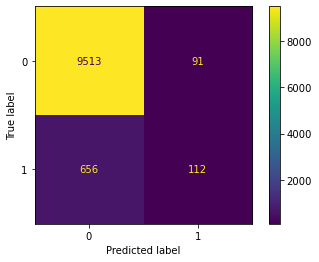

In [41]:
# Confusion matrix - testing

cm = confusion_matrix(y_test, pred_tst, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

*Node2Vec Parameters*

In [42]:
# Node2Vec Embedding - Use parameters set in node2vec paper

node2vec = Node2Vec(G_sample, dimensions=100, p=0.5, q=2, walk_length=10, num_walks=80, seed=42)
model = node2vec.fit(window=10)

Computing transition probabilities:   0%|          | 0/51856 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 80/80 [01:41<00:00,  1.27s/it]


In [43]:
# Get Embedding as DataFrame

emb_df = (pd.DataFrame([model.wv.get_vector(str(n)) for n in G_sample.nodes()]))
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.027270,0.538278,0.787143,0.233711,0.570094,-0.194816,0.142809,0.571221,-0.028449,0.011739,...,0.209228,0.046407,0.051570,-0.002648,0.604615,-0.086204,0.479220,-0.388378,-0.406922,-0.708049
1,0.181662,0.982898,0.963229,0.479386,0.373006,-0.239655,-0.302032,0.873567,-0.907775,0.336730,...,0.400884,0.336403,0.262946,-0.012977,1.003130,-0.268362,0.452574,-0.265178,-0.352706,0.872464
2,0.418079,0.522921,0.386028,-0.322120,-0.407107,-0.831720,-0.384758,0.609201,-0.644736,-0.633886,...,-0.341881,-0.235966,0.573080,-0.318222,1.052176,-0.049862,0.342245,-0.326902,0.168778,0.663090
3,-0.250257,0.162390,0.280271,0.600539,0.199177,-0.019584,-0.846131,0.646036,-0.774746,-0.454448,...,-0.188468,0.368484,0.371010,0.150063,0.597965,0.313499,-0.283214,-0.436023,-0.165516,0.709075
4,-0.487036,0.089973,1.012615,0.272676,0.548678,-0.763373,-0.866539,1.089965,0.256574,0.004732,...,0.383417,0.435064,-0.225958,0.399308,0.796924,0.543010,-0.607836,-0.553120,0.313642,0.784929


In [44]:
# Get train-test-split

x_train, x_test, y_train, y_test = train_test_split(emb_df, flag, test_size=0.2, random_state=42)

In [45]:
# Set Model
xgbc = XGBClassifier(gamma=0.4, learning_rate=0.6, max_depth=7, n_estimators=90, reg_alpha=0.4, reg_lambda=1.6,
                     random_state=42)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)

In [46]:
# Performance

pred_tr = xgbc.predict(x_train)
pred_tst = xgbc.predict(x_test)

print('Classifier with node2vec hyperparameter embeddings')
print(' ')
print('Scores for flag=1')
print('In-sample F1 score: ', f1_score(y_train, pred_tr))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst))
print('In-sample Recall score: ', recall_score(y_train, pred_tr))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst))
print(' ')
print('Overall Scores')
print('In-sample F1 score: ', f1_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst, average='weighted'))
print('In-sample Recall score: ', recall_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst, average='weighted'))

Classifier with node2vec hyperparameter embeddings
 
Scores for flag=1
In-sample F1 score:  1.0
Out-of-sample F1 score:  0.26528497409326424
In-sample Recall score:  1.0
Out-of-sample Recall score:  0.16666666666666666
 
Overall Scores
In-sample F1 score:  1.0
Out-of-sample F1 score:  0.9124057965177262
In-sample Recall score:  1.0
Out-of-sample Recall score:  0.9316428846895488


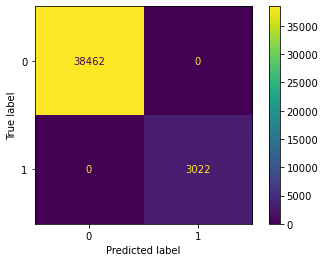

In [47]:
# Confusion matrix - training

cm = confusion_matrix(y_train, pred_tr, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

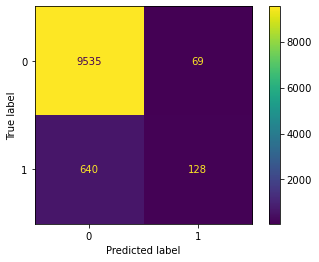

In [48]:
# Confusion matrix - testing

cm = confusion_matrix(y_test, pred_tst, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

*DeepWalk Parameters*

In [49]:
# Node2Vec Embedding - Use parameters set in DeepWalk paper

DeepWalk = Node2Vec(G_sample, dimensions=128, p=1, q=1, walk_length=10, num_walks=80, seed=42)
model = DeepWalk.fit(window=10)

Computing transition probabilities:   0%|          | 0/51856 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 80/80 [01:48<00:00,  1.36s/it]


In [50]:
# Get Embedding as DataFrame

emb_df = (pd.DataFrame([model.wv.get_vector(str(n)) for n in G_sample.nodes()]))
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.116572,0.012397,-0.113650,0.195807,0.321285,0.047590,-0.094790,0.117872,0.070857,0.567988,...,-0.103548,-0.325743,0.179575,0.129786,0.074102,-0.588281,-0.077452,-0.362276,-0.105145,-0.183302
1,0.090447,-0.742487,0.528586,0.754520,0.143256,-0.572822,0.280684,1.000723,-0.061295,0.034991,...,0.286499,0.205860,-0.300694,-0.502550,0.247341,-0.097389,-0.201394,-0.802958,-0.520679,-0.253931
2,-0.740172,0.322069,-0.387997,0.376565,-0.754778,-0.826606,0.018459,0.177940,-0.784380,-0.101303,...,-0.095227,-0.141957,-0.339197,-0.430199,0.123754,-0.231014,-0.053857,-0.483608,-0.554849,-0.194404
3,-0.092945,-0.280920,0.100708,0.518615,-0.011951,-0.232505,0.252681,-0.185301,0.484156,-0.284158,...,-0.161927,0.358503,0.087785,-0.150977,0.082215,0.149481,0.171644,-0.595003,0.043076,-0.512724
4,-0.214413,-0.196422,-0.130398,0.058327,-0.461860,-0.368849,-0.382635,0.536652,-0.024318,0.639259,...,0.296406,0.423094,-0.026433,-0.032628,0.049607,-0.088232,-0.092782,-0.166070,-0.286470,0.263831


In [51]:
# Get train-test-split

x_train, x_test, y_train, y_test = train_test_split(emb_df, flag, test_size=0.2, random_state=42)

In [52]:
# Set Model
xgbc = XGBClassifier(gamma=0.4, learning_rate=0.6, max_depth=7, n_estimators=90, reg_alpha=0.4, reg_lambda=1.6,
                     random_state=42)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)

In [53]:
# Performance

pred_tr = xgbc.predict(x_train)
pred_tst = xgbc.predict(x_test)

print('Classifier with DeepWalk hyperparameter embeddings')
print(' ')
print('Scores for flag=1')
print('In-sample F1 score: ', f1_score(y_train, pred_tr))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst))
print('In-sample Recall score: ', recall_score(y_train, pred_tr))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst))
print(' ')
print('Overall Scores')
print('In-sample F1 score: ', f1_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst, average='weighted'))
print('In-sample Recall score: ', recall_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst, average='weighted'))

Classifier with DeepWalk hyperparameter embeddings
 
Scores for flag=1
In-sample F1 score:  1.0
Out-of-sample F1 score:  0.2383419689119171
In-sample Recall score:  1.0
Out-of-sample Recall score:  0.14973958333333334
 
Overall Scores
In-sample F1 score:  1.0
Out-of-sample F1 score:  0.909193597236289
In-sample Recall score:  1.0
Out-of-sample Recall score:  0.9291361357500965


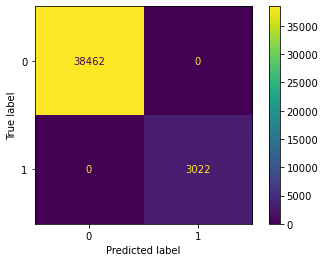

In [54]:
# Confusion matrix - training

cm = confusion_matrix(y_train, pred_tr, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

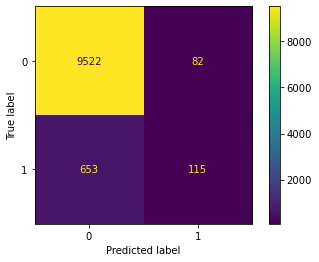

In [55]:
# Confusion matrix - testing

cm = confusion_matrix(y_test, pred_tst, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

## Notes:

- Increasing the the number of k-folds in cross-validation from 10 to 20, and then to 50 did not change the best estimators given by the search
- Increasing the testing sample from 20% to 30% didn't significantly change scores
- The RandomizedSearch was first run for all the different embeddings obtained but the resulting best estimators were all the same. Given the size of the data and the time taken to run these searches only 1 RandomizedSearch was left to improve code efficiency
- The embeddings used for node2vec embeddings were as specified by the papers for trans2vec (Who are the Phisers? Phising Scam Detection on Ethereum), node2vec (node2vec: Scalable Feature Learning for Networks) and DeepWalk (DeepWalk: Online Learning of Social Representation)
- For preliminary further analysis of the sample the hyperparameters specified by trans2vec are used. This is because the intuition behind the choice is better representative to the nature of the data. These parameters were also less computationally expensive then the other options, yet still achieved similar results.